In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
from uav_active_sensing.config import PROCESSED_DATA_DIR
from uav_active_sensing.pytorch_dataloaders import TinyImageNetDataset

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import resize

2025-01-30 10:48:58.207 | INFO     | uav_active_sensing.config:<module>:11 - PROJ_ROOT path is: /home/tcouso/uav_active_sensing


In [3]:
cifar10_processed_dir = PROCESSED_DATA_DIR / "cifar10"

cifar10_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train_dataset = datasets.CIFAR10(
    root=cifar10_processed_dir, train=True, download=False, transform=cifar10_transform
)
cifar10_test_dataset = datasets.CIFAR10(
    root=cifar10_processed_dir, train=False, download=False, transform=cifar10_transform
)

cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=1, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=1, shuffle=False)

In [4]:

TINY_IMAGENET_PROCESSED_DIR = PROCESSED_DATA_DIR / "tiny_imagenet/tiny-imagenet-200"

tiny_imagenet_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tiny_imagenet_train_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="train", transform=tiny_imagenet_transform
)
tiny_imagenet_val_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="val", transform=tiny_imagenet_transform
)

tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, shuffle=True)
tiny_imagenet_val_loader = DataLoader(tiny_imagenet_val_dataset, batch_size=1, shuffle=False)

In [5]:
# Class labels for CIFAR-10
classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Function to visualize images from a batch


def visualize_batch(images, labels, classes, num_samples=1):
    plt.figure(figsize=(12, 5))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        image = images[i].permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.title(classes[labels[i].item()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

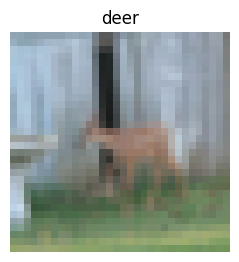

In [6]:
# Get a sample batch from the DataLoader
sample_batch = next(iter(cifar10_train_loader))
images, labels = sample_batch

# Visualize the first 10 images from the batch
visualize_batch(images, labels, classes, num_samples=1)

In [ ]:
def visualize_tensors(tensor1, tensor2):
    """
    Visualizes two PyTorch tensors as images side by side.
    If tensors are 3D (e.g., RGB), they will be shown as color images.
    If tensors are 2D, they will be shown as grayscale images.

    Args:
        tensor1 (torch.Tensor): The first tensor to display.
        tensor2 (torch.Tensor): The second tensor to display.
    """
    # Ensure tensors are at least 2D
    if tensor1.dim() < 2 or tensor2.dim() < 2:
        raise ValueError("Tensors must be at least 2D.")

    # If tensors are 3D, check if they represent RGB images (channels last)
    if tensor1.dim() == 3 and tensor1.shape[0] in {3, 1}:  # RGB or grayscale
        tensor1 = tensor1.permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
    if tensor2.dim() == 3 and tensor2.shape[0] in {3, 1}:  # RGB or grayscale
        tensor2 = tensor2.permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C)

    # Plot both tensors as images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # First tensor
    axes[0].imshow(tensor1.numpy())
    axes[0].set_title("Tensor 1")
    axes[0].axis('off')  # Hide axis

    # Second tensor
    axes[1].imshow(tensor2.numpy())
    axes[1].set_title("Tensor 2")
    axes[1].axis('off')  # Hide axis

    plt.show()


In [229]:

class ImageEnv:
    def __init__(
        self, image: torch.Tensor,
        img_FoV_ratio: int,
        min_altitude: int,
        max_altitude: int,
        device: str = "cpu"
    ) -> None:
        
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = device
        self.img = image.to(self.device)
        self.img_FoV_ratio = img_FoV_ratio
        self.min_altitude = min_altitude
        self.max_altitude = max_altitude

        self.height, self.width = image.shape[1:]
        self.FoV_height = self.height // self.img_FoV_ratio
        self.FoV_width = self.width // self.img_FoV_ratio


        self._position = [0, 0, self.min_altitude]
        self.max_FoV_coor = [self.height - self.FoV_height, self.width - self.FoV_width, self.max_altitude]
        self.min_FoV_coor = [0, 0, self.min_altitude]

        self.max_zoom_level = 1
        self.min_zoom_level = max(
            self.height // self.FoV_height, 
            self.width // self.FoV_width)

        self.sampled_img = torch.full_like(self.img, float('nan'), device=self.device)

        self.curr_FoV = self.img[:, 0:self.FoV_height,0:self.FoV_width]

    @property
    def position(self):
        return tuple(self._position)

    @position.setter
    def position(self, new_position):
        x, y, z = new_position
        self._position[0] = max(min(x, self.max_FoV_coor[0]), self.min_FoV_coor[0])
        self._position[1] = max(min(y, self.max_FoV_coor[1]), self.min_FoV_coor[1])
        self._position[2] = max(min(z, self.max_FoV_coor[2]), self.min_FoV_coor[2])

    @property
    def zoom_level(self):
        m = (self.min_zoom_level - self.max_zoom_level) / (self.max_altitude - self.min_altitude)
        b = self.max_zoom_level - m * self.min_altitude
        
        return m * self._position[2] + b

    def apply_blur(self, window):
        kernel_size = max(1, int(self.zoom_level))  # Blur increases with zoom level
        kernel_size = kernel_size if kernel_size % 2 == 1 else kernel_size + 1
        blurred = F.avg_pool2d(window.unsqueeze(0), kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
        
        return blurred.squeeze(0)

    def observe(self):
        # TODO: Implement priority sampling for lower altitude (high zoom) samples
        
        zoomed_size_height = int(self.FoV_height * self.zoom_level)
        zoomed_size_width = int(self.FoV_width * self.zoom_level)

        top = max(0, self.position[0])
        left = max(0, self.position[1])
        bottom = min(self.height, self.position[0] + zoomed_size_height)
        right = min(self.width, self.position[1] + zoomed_size_width)

        zoomed_window = self.img[:, top:bottom, left:right]

        if self.zoom_level > self.max_zoom_level:
            blurred_window = self.apply_blur(zoomed_window)
            resized_window = F.interpolate(
                blurred_window.unsqueeze(0), 
                size=(self.FoV_height, self.FoV_width), 
                mode='bilinear', align_corners=False
            )
            self.curr_FoV[:, :, :] = resized_window.squeeze(0)
            obs = F.interpolate(resized_window, size=(zoomed_size_height, zoomed_size_width), mode='nearest')
            obs = obs.squeeze(0)

        else:
            obs = zoomed_window
        
        self.sampled_img[:, top:bottom, left:right] = obs
    

    def move(self, dx: int, dy: int, dz: int):
        self.position = (
            self._position[0] + dy,
            self._position[1] + dx,
            self._position[2] + dz
        )

        self.observe()
        


min altitude:  10
max altitude:  100
min zoom level:  8
max zoom level:  1
altitude:  10
zoom level:  1.0


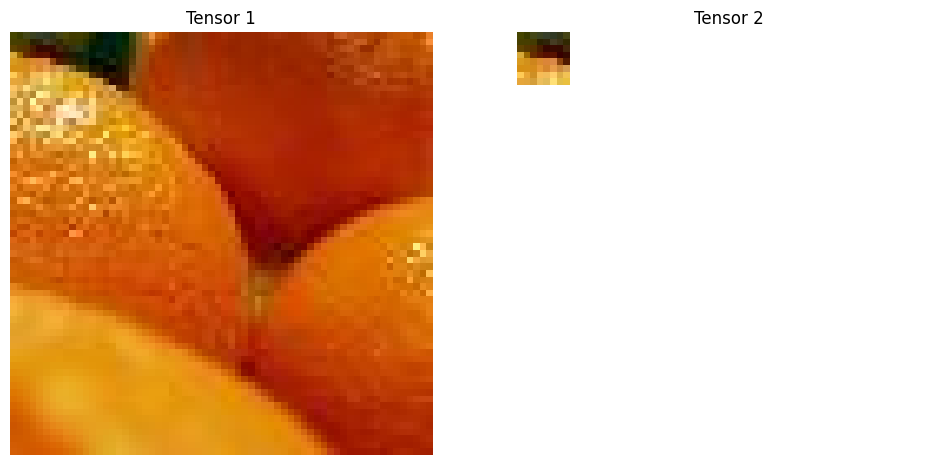

altitude:  20
zoom level:  1.7777777777777777


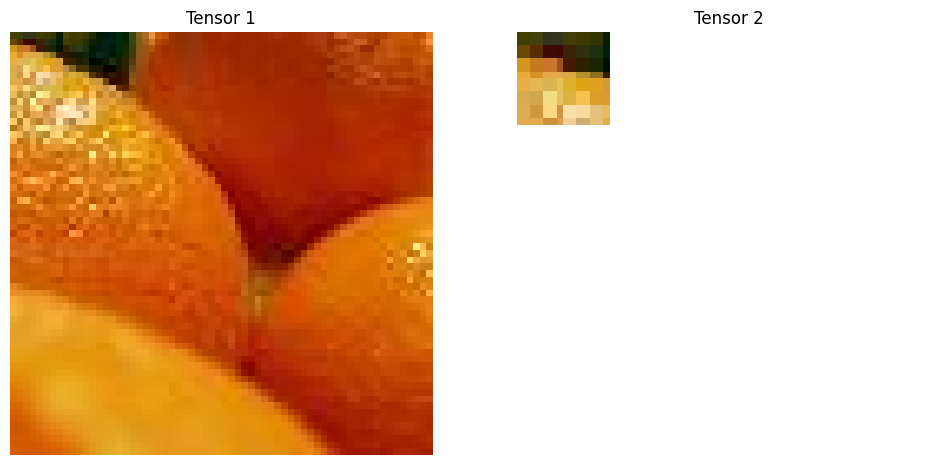

altitude:  30
zoom level:  2.555555555555556


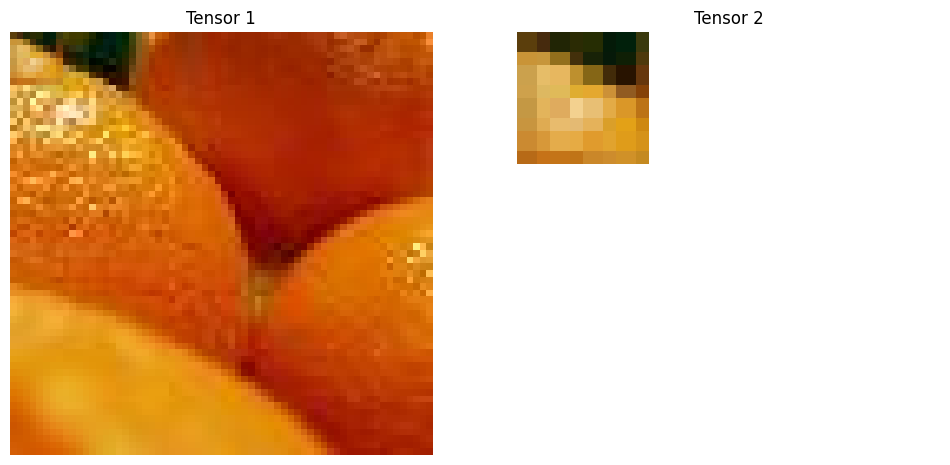

altitude:  40
zoom level:  3.3333333333333335


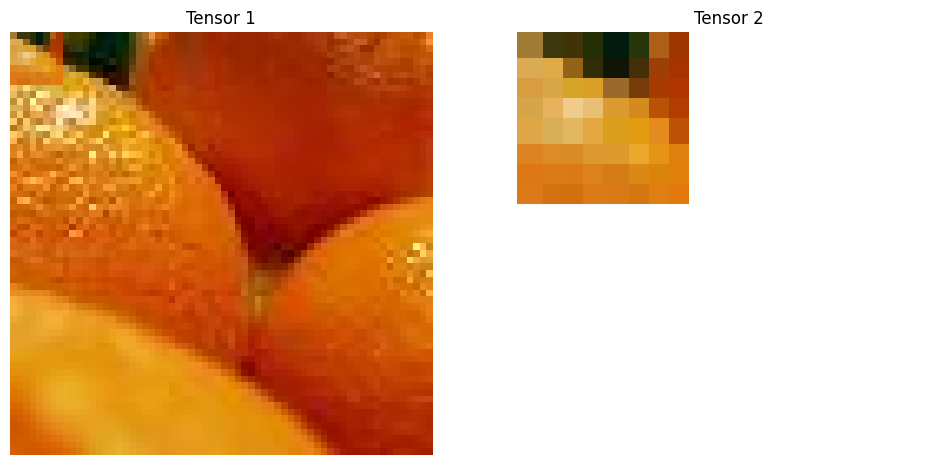

altitude:  50
zoom level:  4.111111111111111


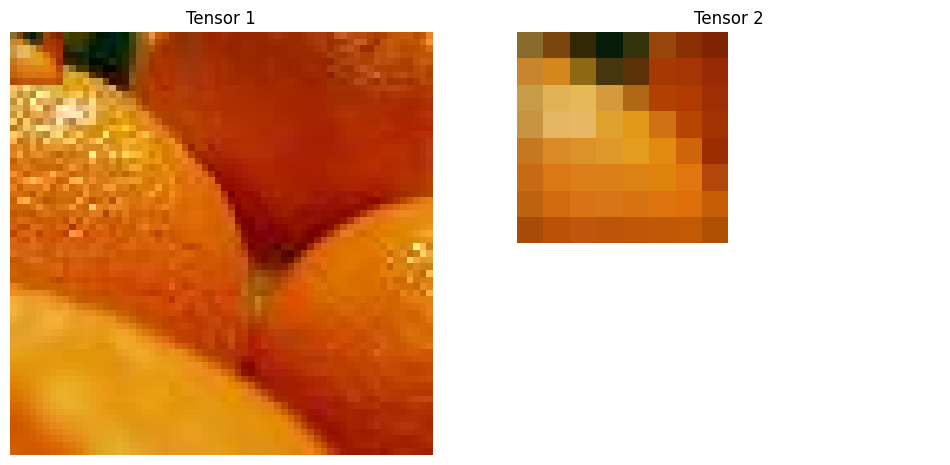

altitude:  60
zoom level:  4.888888888888889


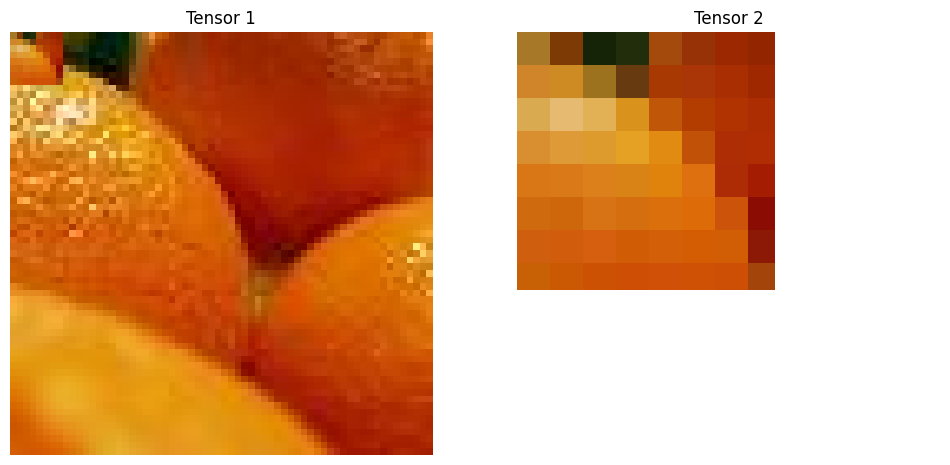

altitude:  70
zoom level:  5.666666666666667


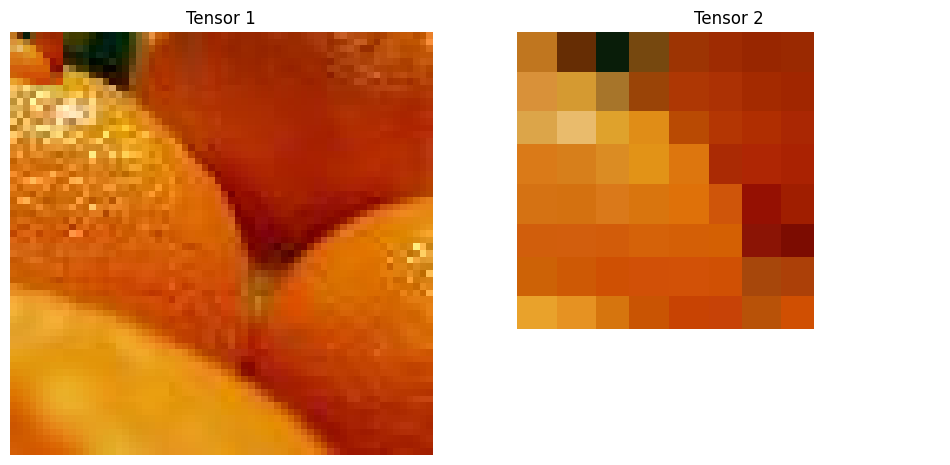

altitude:  80
zoom level:  6.444444444444445


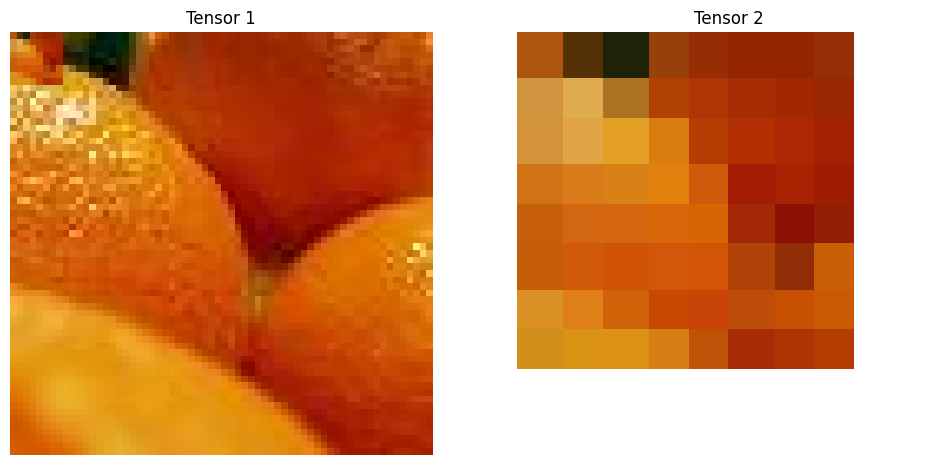

altitude:  90
zoom level:  7.222222222222222


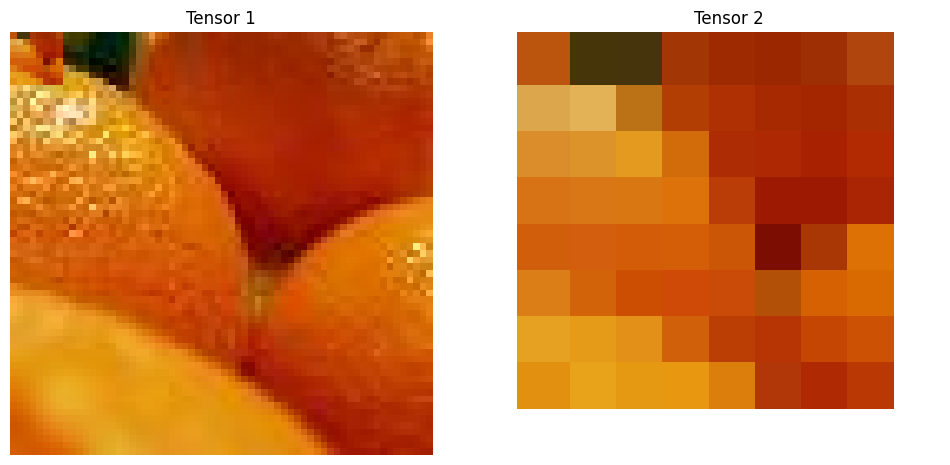

altitude:  100
zoom level:  8.0


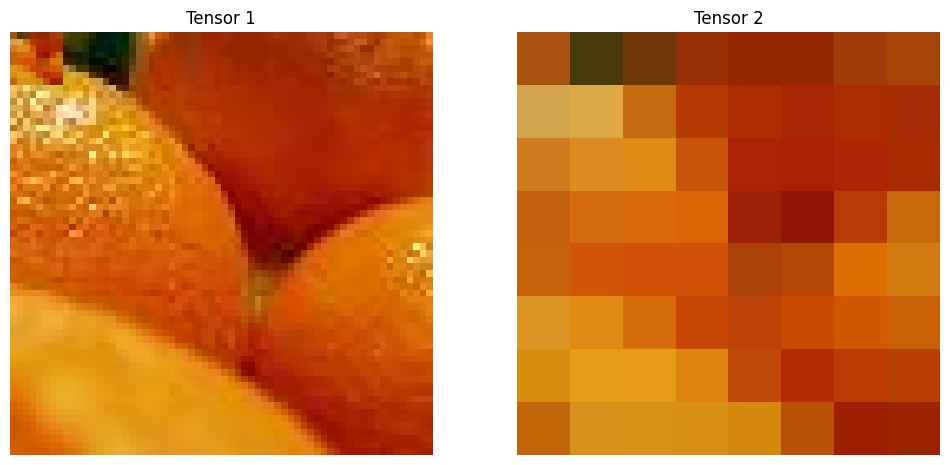

In [230]:
MIN_ALTITUDE = 10
MAX_ALTITUDE = 100
IMG_FOV_RATIO = 8

image, label = tiny_imagenet_train_dataset[3001]
env = ImageEnv(image, IMG_FOV_RATIO, MIN_ALTITUDE, MAX_ALTITUDE)

print("min altitude: ", env.min_altitude)
print("max altitude: ", env.max_altitude)

print("min zoom level: ", env.min_zoom_level)
print("max zoom level: ", env.max_zoom_level)


obs = env.move(0, 0, 0)
for i in range(10):

  print("altitude: ", env.position[2])
  print("zoom level: ", env.zoom_level)
  visualize_tensors(env.img, env.sampled_img)
  env.move(0, 0, 10)




In [199]:
# TODO: Implement image as environment, following common interface (gymnasium problably)
# TODO: Implement reward model (with pretrained MAE) inside the env mechanics

# Everything nice and decoupled!